In [1]:
%matplotlib inline
import h2o
import xgboost
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
from sklearn.metrics import *
import matplotlib.pylab as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from h2o.estimators.random_forest import H2ORandomForestEstimator
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Function

In [2]:
def str_to_num(df, train=True):
    '''
    ppl_id : del string and change dtype to num
    activity id : del number and str(act)
    type : del string and change dtype to num
    bool : 0, 1
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    train : bool
        train :True, test : False
    --------
    '''
    col_list = list(df)
    col_list.remove('date_x')
    col_list.remove('date_y')
    if train:
        col_list.remove('outcome')
        
        
    for col in col_list[:col_list.index('char_9_y')+1]:
        if col == 'activity_id':
            df.loc[:,col] = df.loc[:,col].apply(lambda x: x.split('_')[0])
            df.replace('act', '', regex=True, inplace = True)
        elif col == 'people_id':
            df.loc[:,col] = df.loc[:,col].apply(lambda x: x.split('_')[1])
        else :
            df.loc[:,col][df.loc[:,col].isnull()==False] = df.loc[:,col][df.loc[:,col].isnull()==False].apply(lambda x: x.split(' ')[1])
        df_merge.loc[:, col] = pd.to_numeric(df_merge.loc[:, col][df_merge.loc[:,col].isnull()==False]).astype(int)
            
    for col in col_list[col_list.index('char_10_y'):col_list.index('char_38')+1]:
        df.loc[:,col] = df.loc[:,col].replace({True:1, False:0})
        
    return df

In [3]:
def date_modify(df):
    '''
    add week_x, week_y, and Past_days
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    df.insert(loc=list(df).index('date_x')+1 ,column='week_x', value=df['date_x'].dt.weekday)
    df.insert(loc=list(df).index('date_y')+1 ,column='week_y', value=df['date_y'].dt.weekday)
    df.insert(loc=list(df).index('week_x')+1 ,column='Past_days', value=(df.date_x - df.date_y).astype('timedelta64[D]'))
    return df

In [4]:
def add_bool_sum(df):
    '''
    add colum 'bool_sum' : sum of char_10_y ~ char_37
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    temp = df.copy()
    temp['bool_sum'] = temp.iloc[:,list(temp).index('char_10_y'):list(temp).index('char_37')].sum(axis=1)
    return temp

In [5]:
def num_to_cat(df, columns):
    '''
    change dtype(num to str)
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    columns : list
    --------
    '''
    temp = df.copy()
    temp.loc[:,columns] = pd.DataFrame(temp.loc[:,columns], dtype='str')
    return temp

In [6]:
def one_hot_encoder(df, columns):
    '''
    columns encoding(one-hot-encoding)
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    columns : list
    --------
    '''
    temp = df.copy()
    for col in columns:
        for i in list(pd.get_dummies(temp[col]))[-1::-1]:    
            temp.insert(loc=list(temp).index(col)+1 ,column=col+str(i), value=pd.get_dummies(temp.loc[:,col]).loc[:,i])
        temp = temp.drop([col], axis=1)
    return temp

In [7]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

# 강사님 함수
def draw_decision_tree(model, feature_names):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

# data load & 전처리

### train data

In [32]:
df_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
df_people = pd.read_csv('./data/people.csv', parse_dates=['date'])
df_merge = pd.merge(df_train, df_people, on='people_id')

In [ ]:
df_merge1 = df_merge.copy()

In [9]:
str_to_num(df_merge, train=True)
date_modify(df_merge)
df_merge = add_bool_sum(df_merge)
del df_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
df_merge.dtypes

people_id                     int32
activity_id                   int32
date_x               datetime64[ns]
week_x                        int64
Past_days                   float64
activity_category             int32
char_1_x                    float64
char_2_x                    float64
char_3_x                    float64
char_4_x                    float64
char_5_x                    float64
char_6_x                    float64
char_7_x                    float64
char_8_x                    float64
char_9_x                    float64
char_10_x                   float64
outcome                       int64
char_1_y                      int32
group_1                       int32
char_2_y                      int32
date_y               datetime64[ns]
week_y                        int64
char_3_y                      int32
char_4_y                      int32
char_5_y                      int32
                          ...      
char_15                       int64
char_16                     

### test data

In [11]:
df_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
df_merge_test = pd.merge(df_test, df_people, how='inner', on='people_id')

In [12]:
# submissin 만들때 필요함
df_test_act_id = df_merge_test.activity_id.copy()

In [13]:
str_to_num(df_merge_test, train=False)
date_modify(df_merge_test)
df_merge_test = add_bool_sum(df_merge_test)
del df_test, df_people

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### save data

In [14]:
# df_merge.to_csv("train_merge.csv")
# df_merge_test.to_csv("test_merge.csv")

In [15]:
# df_merge = pd.read_csv('./train_merge.csv', parse_dates=['date_x', 'date_y'])
# df_merge_test = pd.read_csv('./test_merge.csv', parse_dates=['date_x', 'date_y'])

# EDA

In [16]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_merge[d].min().date()))
    print('  End of ' + d + ': ' + str(df_merge[d].max().date()))
    print('Range of ' + d + ': ' + str(df_merge[d].max() - df_merge[d].min()) + '\n')

Start of date_x: 2022-07-17
  End of date_x: 2023-08-31
Range of date_x: 410 days 00:00:00

Start of date_y: 2020-05-18
  End of date_y: 2023-08-31
Range of date_y: 1200 days 00:00:00



In [17]:
df_merge.describe()

,people_id,activity_id,week_x,Past_days,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,outcome,char_1_y,group_1,char_2_y,week_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,bool_sum
count,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,2.039676e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06
mean,2.023863e+05,1.928268e+00,3.231972e+00,2.593235e+02,2.997433e+00,6.932449,5.188389,3.932145,2.799023,3.579881,2.010443,2.554275,5.275538,7.200761,5.038379e+02,4.439544e-01,1.906321e+00,1.620591e+04,2.448956e+00,3.142312e+00,1.786501e+01,1.223861e+01,5.760739e+00,2.744043e+00,1.077467e+01,3.093629e+00,3.476141e+00,2.412662e-01,2.065225e-01,2.348000e-01,3.494708e-01,2.551328e-01,2.619935e-01,2.682617e-01,2.797153e-01,1.774453e-01,2.711939e-01,2.087648e-01,2.685976e-01,2.692215e-01,2.841649e-01,1.807644e-01,3.178951e-01,1.682349e-01,2.334202e-01,2.718370e-01,1.631463e-01,2.038101e-01,2.684724e-01,2.680014e-01,2.140777e-01,3.458008e-01,2.013311e-01,3.282656e-01,2.708326e-01,4.998051e+01,6.741608e+00
std,1.159728e+05,2.580429e-01,1.558017e+00,2.748091e+02,1.314068e+00,6.923220,4.769402,2.150886,1.060304,2.261971,0.815512,1.575641,3.036524,4.936222,1.202242e+03,4.968491e-01,2.913810e-01,9.785621e+03,6.593571e-01,1.528937e+00,1.583957e+01,9.255424e+00,2.724680e+00,1.407350e+00,6.454917e+00,1.548692e+00,1.932350e+00,4.278515e-01,4.048099e-01,4.238739e-01,4.768030e-01,4.359359e-01,4.397192e-01,4.430547e-01,4.488594e-01,3.820452e-01,4.445761e-01,4.064260e-01,4.432302e-01,4.435554e-01,4.510159e-01,3.848229e-01,4.656586e-01,3.740748e-01,4.230074e-01,4.449064e-01,3.694992e-01,4.028295e-01,4.431648e-01,4.429184e-01,4.101811e-01,4.756288e-01,4.009950e-01,4.695821e-01,4.443899e-01,3.608557e+01,9.439904e+00
min,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.032760e+05,2.000000e+00,2.000000e+00,1.700000e+01,2.000000e+00,2.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,4.000000,3.000000,1.000000e+00,0.000000e+00,2.000000e+00,9.107000e+03,2.000000e+00,2.000000e+00,5.000000e+00,6.000000e+00,3.000000e+00,1.000000e+00,7.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.

In [18]:
df_merge[['date_x', 'date_y']].describe()

,date_x,date_y
count,2197291,2197291
unique,411,1196
top,2022-09-30 00:00:00,2022-03-02 00:00:00
freq,48174,55371
first,2022-07-17 00:00:00,2020-05-18 00:00:00
last,2023-08-31 00:00:00,2023-08-31 00:00:00


In [19]:
pd.DataFrame(df_merge.people_id, dtype='object').describe()

,people_id
count,2197291
unique,151295
top,294918
freq,55103


In [20]:
df_merge.people_id.unique()

array([   100, 100002, 100003, ...,   9999,  99992,  99994], dtype=int64)

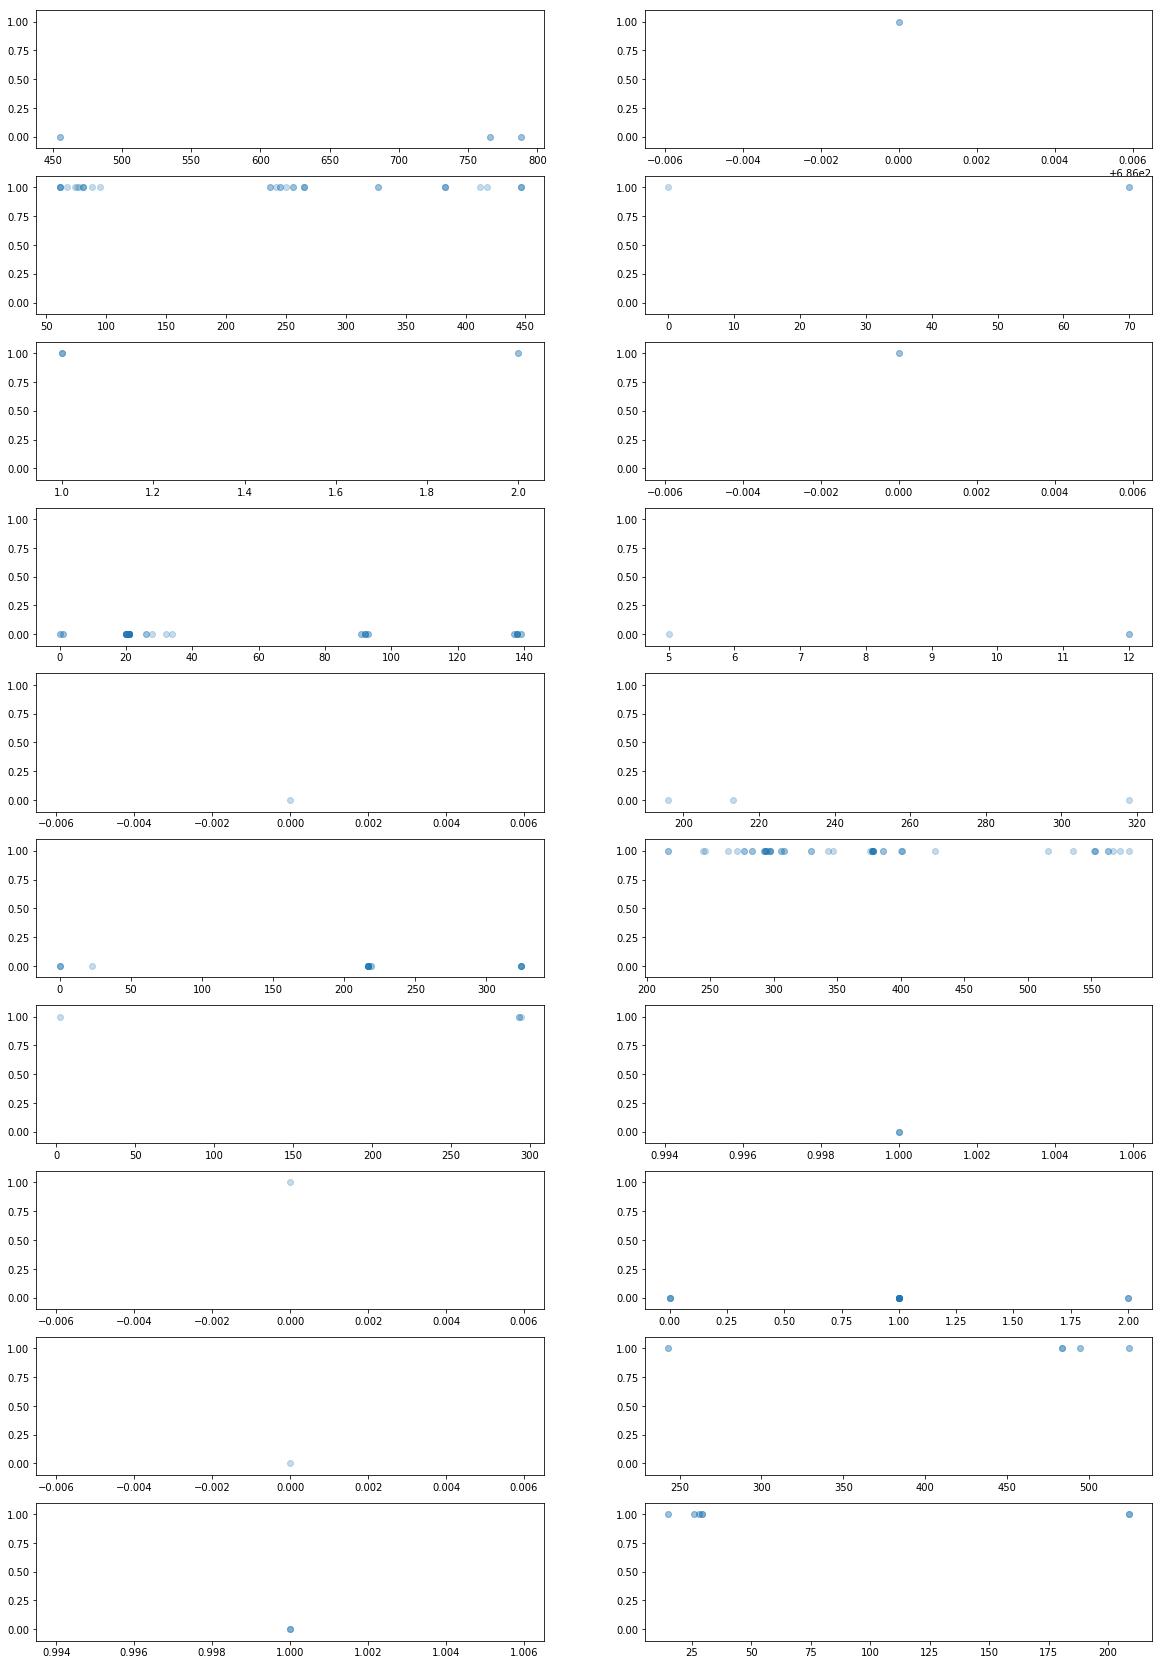

In [21]:
# ppl 별 구매 경향
plt.figure(figsize=(20,30))
for i, ppl in enumerate(df_merge.people_id.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [22]:
df_merge.people_id.value_counts().head()

294918    55103
370270    53668
105739    45936
54699     23969
64887      7052
Name: people_id, dtype: int64

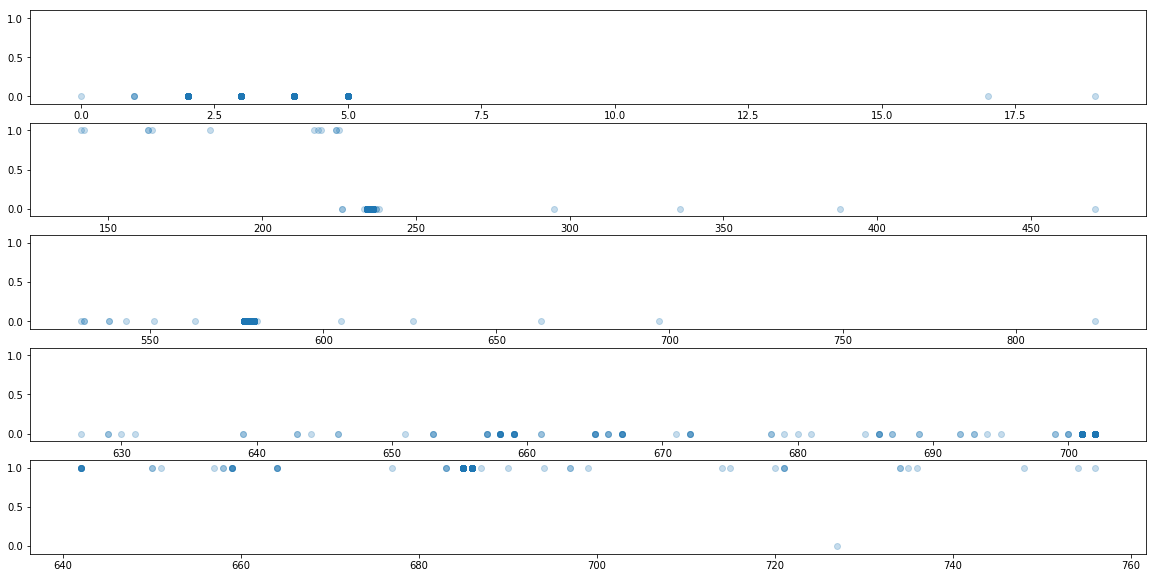

In [23]:
# ppl 별 구매 경향 top 5
plt.figure(figsize=(20,10))
for i, ppl in enumerate([294918, 370270, 105739, 54699, 64887]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

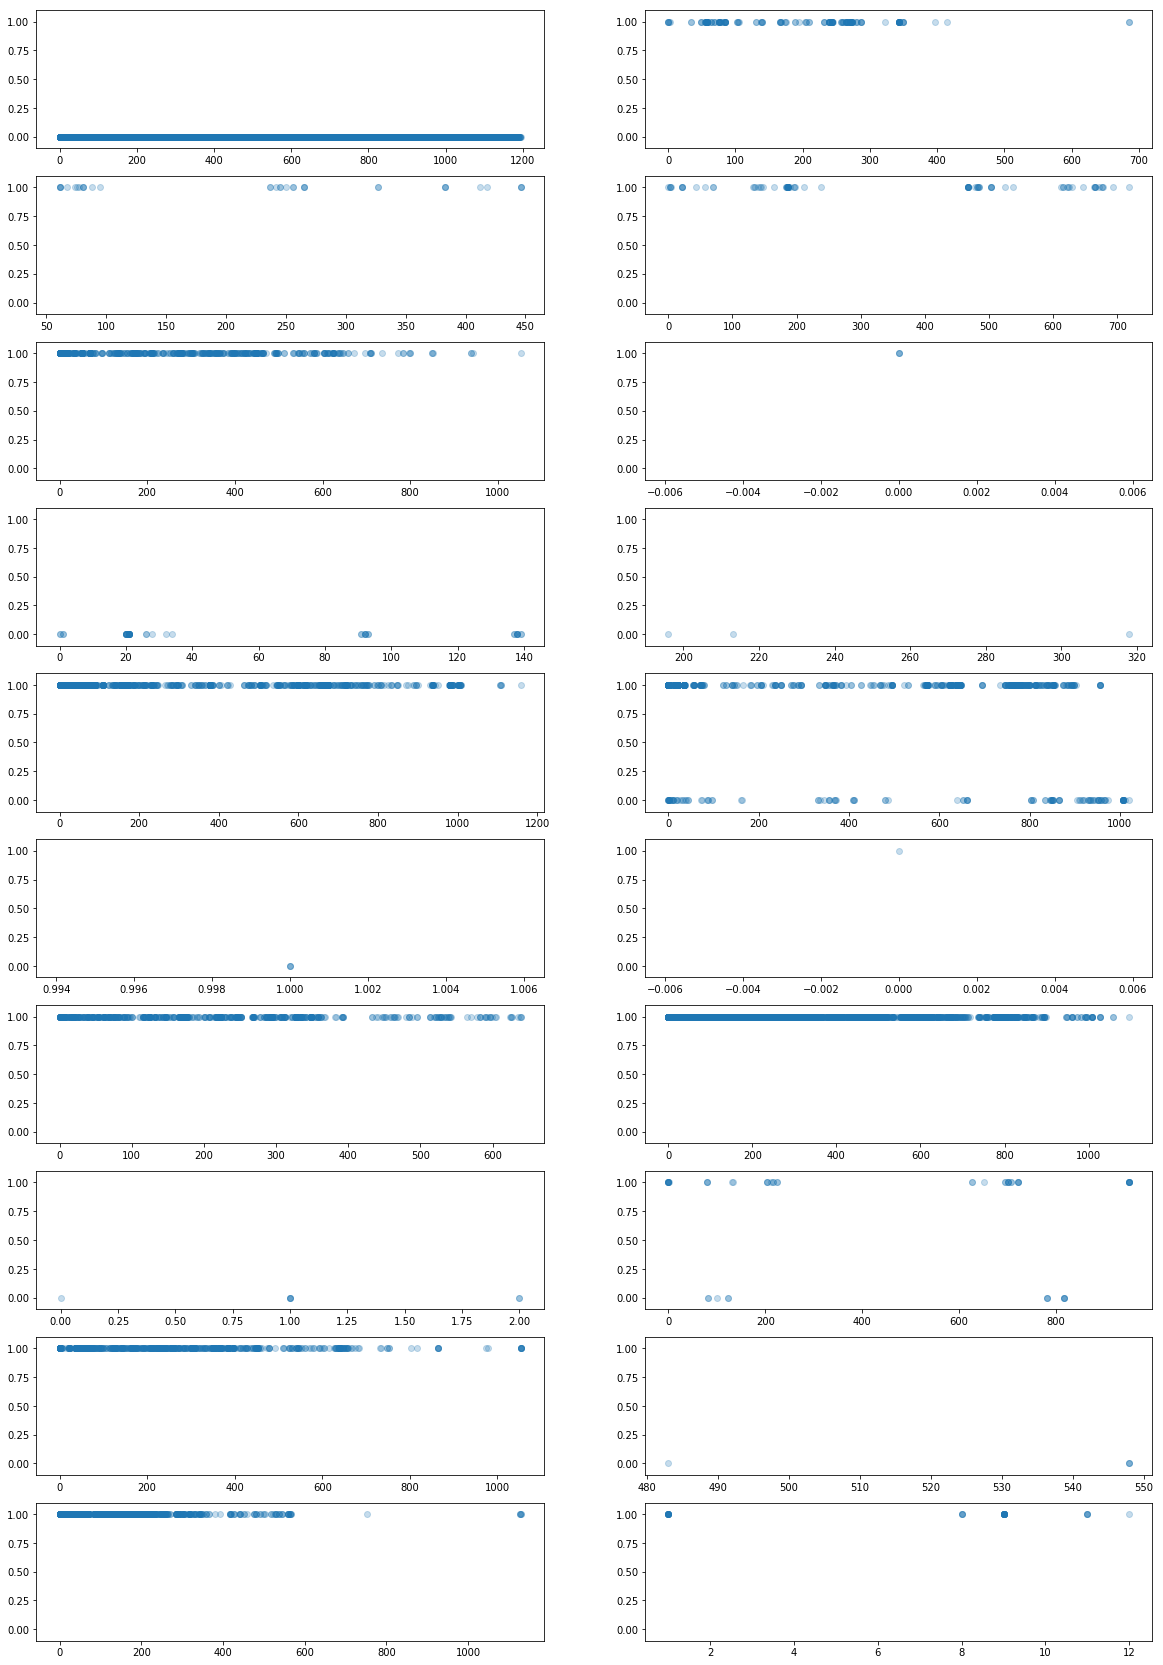

In [24]:
# group 별 구매 경향
plt.figure(figsize=(20,30))
for i, group in enumerate(df_merge.group_1.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

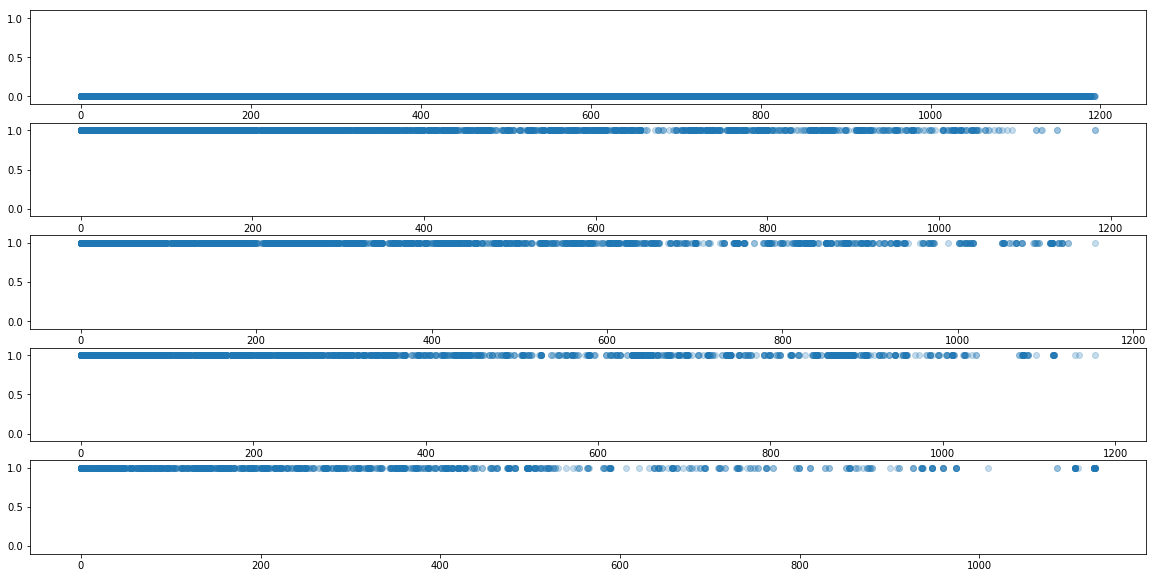

In [25]:
# group 별 구매 경향 top 5

plt.figure(figsize=(20,10))
for i, group in enumerate([17304, 667, 8386, 9280,450]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

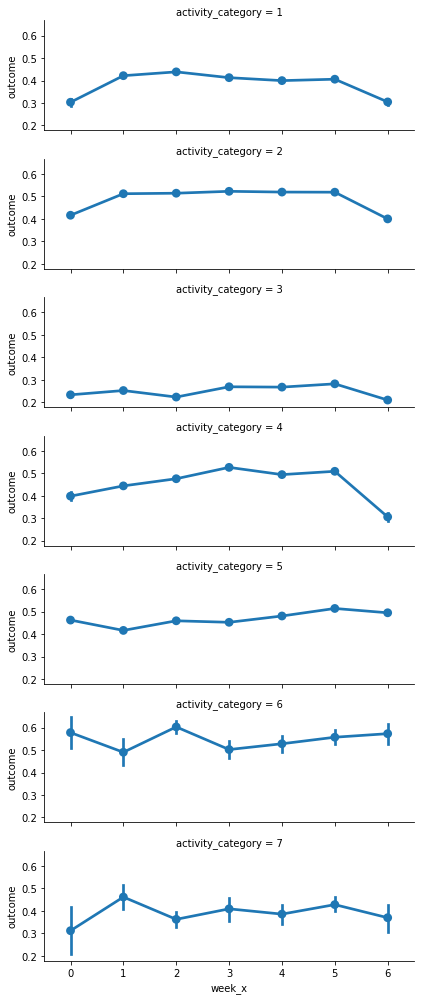

In [26]:
sns.factorplot(x="week_x", y="outcome", row="activity_category", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

KeyboardInterrupt: 

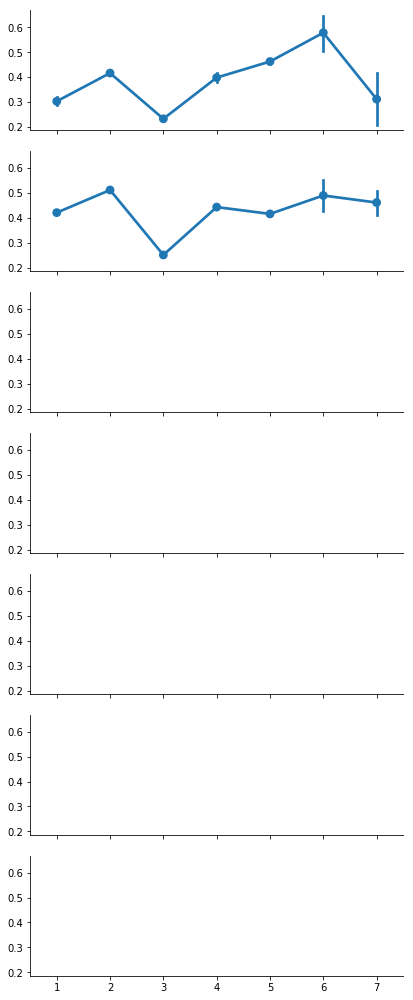

In [27]:
sns.factorplot(x="activity_category", y="outcome", row="week_x", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

#### sample

In [ ]:
df_sample = df_merge.sample(frac = 0.1, random_state=0).copy()
df_sample = add_bool_sum(df_sample)

In [ ]:
df_sample2 = df_merge.sample(frac = 0.1, random_state=1).copy()
df_sample2 = add_bool_sum(df_sample2)

In [ ]:
df_sample.groupby(['activity_id', 'activity_category']).count()

In [ ]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['Past_days'])
sns.kdeplot(df_sample[df_sample.outcome==1]['Past_days'])
plt.show()

In [ ]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['week_x'])
sns.kdeplot(df_sample[df_sample.outcome==1]['week_x'])
plt.show()

#### char_1_x ~ char_9_x

In [ ]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_1_x'):list(df_sample).index('char_9_x')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_2_y ~ char_9_y

In [ ]:
sns.countplot('char_2_y', hue='outcome', data=df_sample)
plt.show

In [ ]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_3_y'):list(df_sample).index('char_9_y')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_10_y ~ char_37

In [ ]:
plt.figure(figsize=(20,30))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_10_y'):list(df_sample).index('char_37')+1]):
    plt.subplot(7,4,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot('bool_sum', hue='outcome', data=df_sample)
plt.show()

#### char_38

In [ ]:
facet = sns.FacetGrid(df_sample, hue='outcome', aspect=4)
facet.map(sns.kdeplot, 'char_38', shade=True)
facet.set(xlim=(0, df_sample['char_38'].max()))
facet.add_legend()

plt.show()

In [ ]:
sns.boxplot(x="outcome", y="char_38", data=df_sample)
plt.show()

In [ ]:
del df_sample, df_sample2

# feature selection

In [ ]:
model1 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + \
                            char_29 + char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37", data=df_merge)
model2 = sm.OLS.from_formula("outcome ~ bool_sum", data=df_merge)
model3 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + char_29 + \
                            char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37 + bool_sum", data=df_merge)
result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()

sm.stats.anova_lm(result1, result2, result3)

In [ ]:
sm.stats.anova_lm(result1)

In [ ]:
sm.stats.anova_lm(result2)

In [ ]:
sm.stats.anova_lm(result3)

# modeling

#### fillna(0)

In [ ]:
df_merge.fillna(0, inplace=True)
df_merge_test.fillna(0, inplace=True)

#### columns

In [ ]:
a = list(df_merge)
a.remove('date_x')
a.remove('date_y')
a.remove('bool_sum')
a.remove('outcome')
print(a)

In [ ]:
b = list(df_merge)
b.remove('date_x')
b.remove('date_y')
b = b[:27]
b.append('bool_sum')
b.remove('outcome')
print(b)

## 로지스틱 회귀분석

In [ ]:
logit_mod = sm.Logit.from_formula("outcome ~ Past_days + char_38 + bool_sum", data=df_merge)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

## 나이브 베이즈

+ 베르누이 분포 나이브 베이즈 모형

In [ ]:
# clf_bern = BernoulliNB().fit(X, y)

In [ ]:
# print(classification_report(df_sample2.outcome, clf_bern.predict(df_sample2[df_sample2.columns[-30:-2]])))

+ 가우시안 정규 분포 나이브 베이즈 모형

In [ ]:
clf_norm = GaussianNB().fit(df_merge[a], df_merge.outcome)

In [ ]:
cvs = cross_val_score(clf_norm, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10)

In [ ]:
cvs.mean()

In [ ]:
print(classification_report(df_merge.outcome, clf_norm.predict(df_merge[a])))

## 의사 결정 나무

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(tree, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
draw_decision_tree(tree, a)

In [ ]:
tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(df_merge[b], df_merge.outcome)

In [ ]:
cross_val_score(tree2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
draw_decision_tree(tree2, b)

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : tree2.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_tree.csv")

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : tree2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_tree_b.csv")

## 랜덤 포레스트

+ RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=30, max_depth=5).fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(rfc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
importance

In [ ]:
importance = rfc.feature_importances_
importance = pd.DataFrame(importance, index=df_merge.loc[:,a].columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]

plt.bar(x, y)

plt.show()

In [ ]:
rfc2 = RandomForestClassifier(n_estimators=30, max_depth=5).fit(df_merge[b], df_merge.outcome)

In [ ]:
cross_val_score(rfc2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
# # rfc = RandomForestClassifier(n_estimators=30).fit(df_merge[a], df_merge.outcome) 0.88
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc.csv")

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc_b.csv")

+ ExtraTreesClassifier

In [ ]:
efc = ExtraTreesClassifier(n_estimators=30, max_depth=5).fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(efc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
efc2 = ExtraTreesClassifier(n_estimators=30, max_depth=5).fit(df_merge[b], df_merge.outcome)

In [ ]:
cross_val_score(efc2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc.csv")

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc_b.csv")

# xgboost

In [ ]:
df_merge2 = one_hot_encoder(df_merge, ['activity_id', 'activity_category'])

In [ ]:
df_merge_test2 = one_hot_encoder(df_merge_test, ['activity_id', 'activity_category'])

In [ ]:
a2 = list(df_merge2)
a2.remove('date_x')
a2.remove('date_y')
a2.remove('bool_sum')
a2.remove('outcome')
print(a2)

In [ ]:
b2 = list(df_merge2)
b2.remove('date_x')
b2.remove('date_y')
b2 = b2[:34]
b2.append('bool_sum')
b2.remove('outcome')
print(b2)

In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=30, max_depth=5).fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(xgb, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
xgb2 = xgboost.XGBClassifier(n_estimators=30, max_depth=5).fit(df_merge[b], df_merge.outcome)

In [ ]:
cross_val_score(xgb2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=30, max_depth=10).fit(df_merge2[a2], df_merge2.outcome)

In [ ]:
cross_val_score(xgb, df_merge2[a2], df_merge2.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : xgb.predict(df_merge_test2[a2])}).set_index('activity_id')
df_submission.to_csv("df_submission_xgb2.csv")

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : xgb2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_xgb_b.csv")

In [37]:
df_merge1 = add_bool_sum(df_merge1)

In [28]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.91-b15, mixed mode)


C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\server.py:258: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kwon\AppData\Local\Temp\tmpaub1_ewc
  JVM stdout: C:\Users\kwon\AppData\Local\Temp\tmpaub1_ewc\h2o_kwon_started_from_python.out
  JVM stderr: C:\Users\kwon\AppData\Local\Temp\tmpaub1_ewc\h2o_kwon_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster version:,3.14.0.7
H2O cluster version age:,26 days
H2O cluster name:,H2O_from_python_kwon_8t2ld0
H2O cluster total nodes:,1
H2O cluster free memory:,247.5 Mb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [42]:
coltype_dict = dict()
ignore_list = ['people_id', 'group_1' , 'char_10_y', 'activity_id', 'outcome']
numeric_list = ['char_38', 'bool_sum']
date_list = ['date_act', 'date_ppl']
for col in list(df_merge1):
    type_ = 'string'
    if col in ignore_list:
        type_ = 'string'
    elif col in numeric_list:
        type_ = 'numeric'
    elif col in date_list:
        type_ = 'time'
    else:
        type_ = 'enum'
    coltype_dict[col] = type_
print(coltype_dict)
print()

na_dict = dict()
na_list = ['char_{}_act'.format(x) for x in range(1, 11)]
for item in na_list:
    na_dict[item] = ['0']
print(na_dict)

{'people_id': 'string', 'activity_id': 'string', 'date_x': 'enum', 'activity_category': 'enum', 'char_1_x': 'enum', 'char_2_x': 'enum', 'char_3_x': 'enum', 'char_4_x': 'enum', 'char_5_x': 'enum', 'char_6_x': 'enum', 'char_7_x': 'enum', 'char_8_x': 'enum', 'char_9_x': 'enum', 'char_10_x': 'enum', 'outcome': 'string', 'char_1_y': 'enum', 'group_1': 'string', 'char_2_y': 'enum', 'date_y': 'enum', 'char_3_y': 'enum', 'char_4_y': 'enum', 'char_5_y': 'enum', 'char_6_y': 'enum', 'char_7_y': 'enum', 'char_8_y': 'enum', 'char_9_y': 'enum', 'char_10_y': 'string', 'char_11': 'enum', 'char_12': 'enum', 'char_13': 'enum', 'char_14': 'enum', 'char_15': 'enum', 'char_16': 'enum', 'char_17': 'enum', 'char_18': 'enum', 'char_19': 'enum', 'char_20': 'enum', 'char_21': 'enum', 'char_22': 'enum', 'char_23': 'enum', 'char_24': 'enum', 'char_25': 'enum', 'char_26': 'enum', 'char_27': 'enum', 'char_28': 'enum', 'char_29': 'enum', 'char_30': 'enum', 'char_31': 'enum', 'char_32': 'enum', 'char_33': 'enum', 'ch

In [43]:
hf_copy1 = h2o.H2OFrame(df_merge1, column_types=coltype_dict, na_strings=na_dict)

H2OServerError: HTTP 500 Server Error:
'<html>\n<head>\n<meta http-equiv="Content-Type" content="text/html;charset=ISO-8859-1"/>\n<title>Error 500 Server Error</title>\n</head>\n<body>\n<h2>HTTP ERROR: 500</h2>\n<p>Problem accessing /3/PostFile. Reason:\n<pre>    Server Error</pre></p>\n<hr /><i><small>Powered by Jetty://</small></i>\n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n</body>\n</html>\n'

In [ ]:
rf_v1.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

In [ ]:
train, valid, test = covtype_df.split_frame([0.6, 0.2], seed=1234)

#Prepare predictors and response columns
covtype_X = covtype_df.col_names[:-1]     #last column is Cover_Type, our desired response variable 
covtype_y = covtype_df.col_names[-1]    

In [ ]:
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=200,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)